In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
import csv
from keras.models import load_model
from pkg_resources import resource_filename
from spliceai.utils import one_hot_encode
from maxentpy import maxent

Using TensorFlow backend.


In [2]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
import os.path as op

In [4]:
import seaborn as sns

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.custom_splai_scores as css
import splanl.create_vcf as vcf

In [7]:
chr11 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 0 ]

In [8]:
isos_in = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [9]:
isos_df = pd.read_table( isos_in + 'wt1_ex9_isoforms_onesamp_2022-0517.txt' )

In [10]:
isos_df = isos_df.set_index( 'isonum' )

In [11]:
bdout = isos_in

In [12]:
bam = '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_JKLab0340_MM1B/BB_test_Cos1053_JKLab0340_MM1BAligned.out.wbcs.bam'

In [13]:
msamp_fn = { bam.split( '/')[ -1 ].split( '.' )[ 0 ].replace( 'Aligned', '' ) : bam }

In [14]:
isogrpdict = { samp: jn.create_iso_dict_no_cnst( isos_df.query( samp + '_filter!=0' ) )
              for samp in msamp_fn }

In [15]:
len( isogrpdict[ 'BB_test_Cos1053_JKLab0340_MM1B' ] )

68

In [16]:
satbls = ! ls /nfs/turbo/umms-kitzmanj/oldvol2/jacob/proj/jensplice/20220426_wt1_subasm_filter_stringent/sapipe/sa/*.haps.all.txt

In [17]:
satbl_fn = { sa.split( '/')[ -1 ].split( '.' )[ 0 ]: pd.read_table( sa ).set_index( 'readgroupid' ) for sa in satbls }

In [18]:
for lib in satbl_fn.keys():
    
    satbl_fn[ lib ] = satbl_fn[ lib ][ [ col for col in satbl_fn[ lib ] if not col.startswith( 'nbp_' ) ] ].copy()

In [19]:
msamp_rnabam = { samp: pysam.AlignmentFile(msamp_fn[samp],'rb') for samp in msamp_fn }

In [20]:
%%time
#52 min
msamp_bcrnatbl = { samp: jn.compute_isoform_counts_pe( msamp_rnabam[ samp ],
                                                               isogrpdict[ samp ],
                                                               [ ( 649, 696 ), ( 3478, 3533 ) ],
                                                               spl_tol = 3,
                                                               indel_tol = 20,
                                                               min_matches_for = 70,
                                                               min_matches_rev = 50,
                                                               count_otherisos = True,
                                                               bc_tag = 'BC' )
                  for samp in msamp_rnabam }

processed 1000 bcs, 31955 reads
processed 2000 bcs, 67678 reads
processed 3000 bcs, 104625 reads
processed 4000 bcs, 135250 reads
processed 5000 bcs, 175518 reads
processed 6000 bcs, 207177 reads
processed 7000 bcs, 238942 reads
processed 8000 bcs, 271519 reads
processed 9000 bcs, 303319 reads
processed 10000 bcs, 331774 reads
processed 11000 bcs, 365298 reads
processed 12000 bcs, 396164 reads
processed 13000 bcs, 430813 reads
processed 14000 bcs, 466631 reads
processed 15000 bcs, 504354 reads
processed 16000 bcs, 540229 reads
processed 17000 bcs, 571677 reads
processed 18000 bcs, 602486 reads
processed 19000 bcs, 632954 reads
processed 20000 bcs, 662173 reads
processed 21000 bcs, 694710 reads
processed 22000 bcs, 728389 reads
processed 23000 bcs, 764562 reads
processed 24000 bcs, 794577 reads
processed 25000 bcs, 823749 reads
processed 26000 bcs, 853002 reads
processed 27000 bcs, 883973 reads
processed 28000 bcs, 923132 reads
processed 29000 bcs, 952445 reads
processed 30000 bcs, 9810

In [21]:
msamp_bcrnatbl_flen = { samp: jn.filter_on_barc_len( msamp_bcrnatbl[ samp ], 30 )
                        for samp in msamp_bcrnatbl }

In [22]:
msamp_bcrnatbl_flen[ 'BB_test_Cos1053_JKLab0340_MM1B' ]

,num_reads,unpaired_reads,secondary_reads,unmapped_reads,bad_starts,bad_ends,soft_clipped,other_isoform,iso000,iso004,...,iso621,iso622,iso631,iso644,iso646,iso649,iso658,iso662,iso697,usable_reads
barcode,,,,,,,,,,,,,,,,,,,,,
A,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AAAAAACAAGCGGCTACTGATGG,53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,53
AAAAAACAAGCGGCTACTTATGG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AAAAAACATTGTAGCAGCGTTGG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AAAAAACATTTGAGCAGCGTTGG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTTTTTCCTGCATATTATGG,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
TTTTTTTTTTGACAGTAGGTTGG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
TTTTTTTTTTTGCACTGGGATGG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


BB_test_Cos1053_JKLab0340_MM1B


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


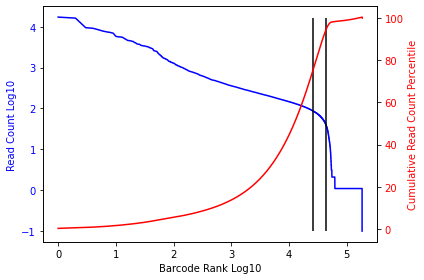

The read count cut off at the 75 th percentile is 87
The read count cut off at the 95 th percentile is 36


In [23]:
read_cut_unfilt_d = { 'sample': [],
                      '75_x': [],
                      '95_x': [],
                      '75_y': [],
                      '95_y': [], }

for samp in msamp_bcrnatbl_flen:
    
    print( samp )
    
    read_cut_unfilt_d[ 'sample' ].append( samp )
    
    x_cuts,y_cuts = sp.waterfall_plot( msamp_bcrnatbl_flen[ samp ],
                                       'usable_reads',
                                       [ 75, 95 ] )
    
    for cut in x_cuts:

        read_cut_unfilt_d[ str( cut ) + '_x' ].append( 10**( x_cuts[ cut ] ) )
        read_cut_unfilt_d[ str( cut ) + '_y' ].append( y_cuts[ cut ] )

In [24]:
read_cut_unfilt = pd.DataFrame( read_cut_unfilt_d )

In [25]:
for col in read_cut_unfilt.columns:
    
    if col.endswith( '_x' ):
        
        read_cut_unfilt[ col + '_log10' ] = np.log10( read_cut_unfilt[ col ].tolist() )

In [26]:
read_cut_unfilt

,sample,75_x,95_x,75_y,95_y,75_x_log10,95_x_log10
0,BB_test_Cos1053_JKLab0340_MM1B,25946.0,44757.0,87,36,4.41407,4.650861


In [27]:
cut_dict = { samp: cut for samp,cut in zip( read_cut_unfilt[ 'sample' ], read_cut_unfilt[ '95_y' ] ) }

In [28]:
msamp_varbcrnatbl_flen_allisos = { lib: { samp: mbcs.merge_subasm_and_rna_tbls( satbl_fn[ lib ],
                                                                                msamp_bcrnatbl_flen[ samp ] )
                                           for samp in msamp_bcrnatbl_flen
                                           if lib.replace( 'JKP', '' ) in samp }
                                   for lib in satbl_fn }

In [29]:
msamp_varbcrnatbl_flen_allisos[ 'JKP1053' ][ 'BB_test_Cos1053_JKLab0340_MM1B' ].head()

,passes,status,n_variants_passing,variant_list,num_reads,unpaired_reads,secondary_reads,unmapped_reads,bad_starts,bad_ends,...,iso621,iso622,iso631,iso644,iso646,iso649,iso658,iso662,iso697,usable_reads
AAAAAACAAGCGGCTACTGATGG,False,possible_chimeric_no_major_variant,1,jkp815:1230:T:C,53,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,53
AAAAAACATTTTAGCAGCGTTGG,False,possible_chimeric_no_major_variant,1,jkp815:1272:A:T,153,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,153
AAAAAATCAAACGGGGTAGATGG,False,possible_chimeric_no_major_variant,2,"jkp815:1311:C:T,jkp815:1320:C:T",60,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,60
AAAAAATGCCTCGTAAGCGATGG,False,possible_chimeric_no_major_variant,1,jkp815:1264:T:A,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26
AAAAACCGGGCATACTATGATGG,False,possible_chimeric_no_major_variant,1,jkp815:1323:C:T,87,0,0,0,0,0,...,0,0,0,0,0,0,84,0,0,87


In [30]:
%%time
for lib in msamp_varbcrnatbl_flen_allisos:

    for samp in msamp_varbcrnatbl_flen_allisos[ lib ]:
    
        msamp_varbcrnatbl_flen_allisos[ lib ][ samp ].to_csv( bdout + samp + '_wt1_ex9_by_bc_effects_allvars_allisos_onesamp-2022-0519.txt',
                                                               sep='\t'
                                                              )

CPU times: user 413 ms, sys: 12 ms, total: 425 ms
Wall time: 533 ms


In [31]:
isonamedict = { 'KTS+': [ (1267, 1359) ],
                'KTS-': [ (1267, 1350) ],
                'SKIP': [] }

In [32]:
namedisogrps = { samp: jn.create_named_isogrps( isogrpdict[ samp ],
                                                isonamedict,
                                                [],
                                                28,
                                                150,
                                                3 )
                for samp in isogrpdict }

In [33]:
msamp_bcrnatbl_flen_rename = { samp: jn.combine_isogrps_pe( namedisogrps[ samp ],
                                                            msamp_bcrnatbl_flen[ samp ] ) 
                               for samp in namedisogrps }

0 columns will be removed during this process.
Columns:  []


In [34]:
msamp_bcrnatbl_flen_rename[ 'BB_test_Cos1053_JKLab0340_MM1B' ]

,num_reads,secondary_reads,unpaired_reads,unmapped_reads,bad_starts,bad_ends,soft_clipped,other_isoform,usable_reads,KTS+,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi
barcode,,,,,,,,,,,,,,,,,
A,1,0,0,0,0,0,0,0,1,0,0,1,0,0.000000,0.000000,1.000000,0.0
AAAAAACAAGCGGCTACTGATGG,53,0,0,0,0,0,0,0,53,49,2,2,0,0.924528,0.037736,0.037736,0.0
AAAAAACAAGCGGCTACTTATGG,1,0,0,0,0,0,0,0,1,1,0,0,0,1.000000,0.000000,0.000000,0.0
AAAAAACATTGTAGCAGCGTTGG,1,0,0,0,0,0,0,0,1,1,0,0,0,1.000000,0.000000,0.000000,0.0
AAAAAACATTTGAGCAGCGTTGG,1,0,0,0,0,0,0,0,1,1,0,0,0,1.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTTTTTCCTGCATATTATGG,15,0,0,0,0,0,0,0,15,15,0,0,0,1.000000,0.000000,0.000000,0.0
TTTTTTTTTTGACAGTAGGTTGG,1,0,0,0,0,0,0,0,1,0,0,1,0,0.000000,0.000000,1.000000,0.0
TTTTTTTTTTTGCACTGGGATGG,1,0,0,0,0,0,0,0,1,1,0,0,0,1.000000,0.000000,0.000000,0.0


In [35]:
msamp_varbcrnatbl_flen_rename = { lib: { samp: mbcs.merge_subasm_and_rna_tbls( satbl_fn[ lib ],
                                                                                msamp_bcrnatbl_flen_rename[ samp ] )
                                          for samp in msamp_bcrnatbl_flen_rename
                                          if lib.replace( 'JKP', '' ) in samp }
                                  for lib in satbl_fn }

In [36]:
msamp_varbcrnatbl_flen_rename[ 'JKP1053' ][ 'BB_test_Cos1053_JKLab0340_MM1B' ]

,passes,status,n_variants_passing,variant_list,num_reads,secondary_reads,unpaired_reads,unmapped_reads,bad_starts,bad_ends,...,other_isoform,usable_reads,KTS+,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi
AAAAAACAAGCGGCTACTGATGG,False,possible_chimeric_no_major_variant,1,jkp815:1230:T:C,53,0,0,0,0,0,...,0,53,49,2,2,0,0.924528,0.037736,0.037736,0.000000
AAAAAACATTTTAGCAGCGTTGG,False,possible_chimeric_no_major_variant,1,jkp815:1272:A:T,153,0,0,0,0,0,...,0,153,144,5,2,2,0.941176,0.032680,0.013072,0.013072
AAAAAATCAAACGGGGTAGATGG,False,possible_chimeric_no_major_variant,2,"jkp815:1311:C:T,jkp815:1320:C:T",60,0,0,0,0,0,...,0,60,56,2,2,0,0.933333,0.033333,0.033333,0.000000
AAAAAATGCCTCGTAAGCGATGG,False,possible_chimeric_no_major_variant,1,jkp815:1264:T:A,26,0,0,0,0,0,...,0,26,2,0,2,22,0.076923,0.000000,0.076923,0.846154
AAAAACCGGGCATACTATGATGG,False,possible_chimeric_no_major_variant,1,jkp815:1323:C:T,87,0,0,0,0,0,...,0,87,1,84,2,0,0.011494,0.965517,0.022989,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTTTCACGTGCGTTCTCTGG,True,pass,1,jkp815:1397:T:A,160,0,0,0,0,0,...,1,160,82,74,3,0,0.512500,0.462500,0.018750,0.000000
TTTTTTTTCATCCGTGTATATGG,False,possible_chimeric_no_major_variant,2,"jkp815:1229:T:G,jkp815:1365:TAAACT:TAACT",125,0,0,0,0,0,...,0,125,2,121,2,0,0.016000,0.968000,0.016000,0.000000
TTTTTTTTGATCGGTGACAGTGG,False,possible_chimeric_no_major_variant,1,jkp815:1241:A:T,122,0,0,0,0,0,...,0,122,1,5,115,1,0.008197,0.040984,0.942623,0.008197
TTTTTTTTGCTAGACGATGATGG,True,no_variants_input,0,NaN,49,0,0,0,0,0,...,0,49,46,1,2,0,0.938776,0.020408,0.040816,0.000000


In [42]:
msamp_varbcrnatbl_flen_rename_filt = { 'JKP1053': { samp: msamp_varbcrnatbl_flen_rename[ 'JKP1053' ][ samp ].loc[ msamp_varbcrnatbl_flen_rename[ 'JKP1053' ][ samp ].usable_reads > cut_dict[ samp ] ].copy()
                                              for samp in msamp_varbcrnatbl_flen_rename[ 'JKP1053' ] } }

In [44]:
%%time
bybcvartbl_long = mbcs.combine_rep_perbctbls_long( [ msamp_varbcrnatbl_flen_rename[ 'JKP1053' ][ samp ] for samp in msamp_varbcrnatbl_flen_rename[ 'JKP1053' ] ],
                                                   [ samp for samp in msamp_varbcrnatbl_flen_rename[ 'JKP1053' ] ] )

CPU times: user 17 ms, sys: 2 µs, total: 17.1 ms
Wall time: 16.5 ms


In [45]:
%%time
bybcvartbl_filt_long = { 'JKP1053': mbcs.combine_rep_perbctbls_long( [ msamp_varbcrnatbl_flen_rename_filt[ 'JKP1053' ][ samp ] for samp in msamp_varbcrnatbl_flen_rename_filt[ 'JKP1053' ] ],
                                                          [ samp for samp in msamp_varbcrnatbl_flen_rename_filt[ 'JKP1053' ] ] ) }

CPU times: user 14.8 ms, sys: 38 µs, total: 14.8 ms
Wall time: 14.3 ms


In [46]:
bybcvartbl_long

,sample,passes,status,n_variants_passing,variant_list,num_reads,secondary_reads,unpaired_reads,unmapped_reads,bad_starts,...,other_isoform,usable_reads,KTS+,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi
barcode,,,,,,,,,,,,,,,,,,,,,
AAAAAACAAGCGGCTACTGATGG,BB_test_Cos1053_JKLab0340_MM1B,False,possible_chimeric_no_major_variant,1,jkp815:1230:T:C,53,0,0,0,0,...,0,53,49,2,2,0,0.924528,0.037736,0.037736,0.000000
AAAAAACATTTTAGCAGCGTTGG,BB_test_Cos1053_JKLab0340_MM1B,False,possible_chimeric_no_major_variant,1,jkp815:1272:A:T,153,0,0,0,0,...,0,153,144,5,2,2,0.941176,0.032680,0.013072,0.013072
AAAAAATCAAACGGGGTAGATGG,BB_test_Cos1053_JKLab0340_MM1B,False,possible_chimeric_no_major_variant,2,"jkp815:1311:C:T,jkp815:1320:C:T",60,0,0,0,0,...,0,60,56,2,2,0,0.933333,0.033333,0.033333,0.000000
AAAAAATGCCTCGTAAGCGATGG,BB_test_Cos1053_JKLab0340_MM1B,False,possible_chimeric_no_major_variant,1,jkp815:1264:T:A,26,0,0,0,0,...,0,26,2,0,2,22,0.076923,0.000000,0.076923,0.846154
AAAAACCGGGCATACTATGATGG,BB_test_Cos1053_JKLab0340_MM1B,False,possible_chimeric_no_major_variant,1,jkp815:1323:C:T,87,0,0,0,0,...,0,87,1,84,2,0,0.011494,0.965517,0.022989,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTTTCACGTGCGTTCTCTGG,BB_test_Cos1053_JKLab0340_MM1B,True,pass,1,jkp815:1397:T:A,160,0,0,0,0,...,1,160,82,74,3,0,0.512500,0.462500,0.018750,0.000000
TTTTTTTTCATCCGTGTATATGG,BB_test_Cos1053_JKLab0340_MM1B,False,possible_chimeric_no_major_variant,2,"jkp815:1229:T:G,jkp815:1365:TAAACT:TAACT",125,0,0,0,0,...,0,125,2,121,2,0,0.016000,0.968000,0.016000,0.000000
TTTTTTTTGATCGGTGACAGTGG,BB_test_Cos1053_JKLab0340_MM1B,False,possible_chimeric_no_major_variant,1,jkp815:1241:A:T,122,0,0,0,0,...,0,122,1,5,115,1,0.008197,0.040984,0.942623,0.008197


In [51]:
bybcvartbl_long.to_csv( bdout + 'wt1_ex9_by_bc_effects_allvars_onesamp-2022-0519.txt',
                                    sep='\t'
                                 )

In [48]:
%%time
msamp_byvartbl_allisos = { lib: { samp: mbcs.summarize_byvar_singlevaronly_pe( satbl_fn[ lib ],
                                                                              msamp_bcrnatbl_flen[ samp ],
                                                                              [ (1267, 1359) ],
                                                                              cut_dict[ samp ],
                                                                              [ 'secondary_reads', 'unpaired_reads', 'unmapped_reads', 'bad_starts', 'bad_ends', 'soft_clipped', 'other_isoform', 'usable_reads', ] )
                                   for samp in msamp_bcrnatbl }
                          for lib in satbl_fn }

CPU times: user 37.6 s, sys: 44.8 ms, total: 37.6 s
Wall time: 37.6 s


In [49]:
msamp_byvartbl_allisos_snvs = { lib: { samp: mbcs.filter_byvartbl_snvonly( msamp_byvartbl_allisos[ lib ][ samp ] )
                                        for samp in msamp_byvartbl_allisos[ lib ] }
                                for lib in msamp_byvartbl_allisos }

In [50]:
msamp_byvartbl_allisos_snvs[ 'JKP1053' ][ 'BB_test_Cos1053_JKLab0340_MM1B' ].head() 

,varlist,chrom,pos,ref,alt,n_bc,n_bc_passfilt,sum_reads,sum_reads_passfilt,sum_secondary_reads,...,per_bc_passfilt,per_reads_passfilt,per_secondary_reads,per_unpaired_reads,per_unmapped_reads,per_bad_starts,per_bad_ends,per_soft_clipped,per_other_isoform,per_usable_reads
1,jkp815:1134:A:G,jkp815,1134,A,G,1,1,192,192,2,...,100.0,100.0,1.041667,0.0,0.0,0.0,0.0,0.0,0.0,98.958333
2,jkp815:1140:A:G,jkp815,1140,A,G,1,1,200,200,0,...,100.0,100.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,100.000000
3,jkp815:1148:G:C,jkp815,1148,G,C,1,1,78,78,0,...,100.0,100.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,100.000000
4,jkp815:1167:C:T,jkp815,1167,C,T,1,0,2,0,0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,jkp815:1175:G:A,jkp815,1175,G,A,1,0,20,0,0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
for lib in msamp_byvartbl_allisos_snvs:

    for samp in msamp_byvartbl_allisos_snvs[ lib ]:

        msamp_byvartbl_allisos_snvs[ lib ][ samp ][ 'hgvs_pos' ] = cds.pos_to_hgvspos( msamp_byvartbl_allisos_snvs[ lib ][ samp ].pos,
                                                                                        ( 1058, 1554 ),
                                                                                        [ (1267, 1359) ],
                                                                                        [ ( 1355, 1447 ), ]
                                                                                     )

In [53]:
lib_byvartbl_allisos_long = { lib: mbcs.combine_allisos_pervartbls_long( [ msamp_byvartbl_allisos_snvs[ lib ][ samp ] for samp in msamp_byvartbl_allisos_snvs[ lib ] ],
                                                                      [ samp for samp in msamp_byvartbl_allisos_snvs[ lib ] ] )
                              for lib in msamp_byvartbl_allisos_snvs } 

In [54]:
for lib in lib_byvartbl_allisos_long:
    
    lib_byvartbl_allisos_long[ lib ].to_csv( bdout + 'wt1_ex9_%s_by_var_effects_allisos_snvs_onesamp-2022-0519.txt' % lib,
                                              sep = '\t',
                                              index = False
                                            )

In [55]:
lib_byvartbl_allisos_long[ 'JKP1053' ]

,sample,wmean_iso247,mean_iso277,mean_iso621,wmean_iso051,median_iso275,median_iso649,mean_iso000,median_iso298,mean_iso300,...,mean_iso644,median_iso658,mean_iso544,mean_iso085,mean_iso334,wmean_iso042,median_iso553,wmean_iso472,median_iso377,sum_soft_clipped
0,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.936842,0.036842,0.0,0.0,0.0,0.0,0.0,0.0,0
1,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.030000,0.930000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.051282,0.923077,0.0,0.0,0.0,0.0,0.0,0.0,0
3,BB_test_Cos1053_JKLab0340_MM1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,BB_test_Cos1053_JKLab0340_MM1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000594,...,0.0,0.075000,0.524954,0.0,0.0,0.0,0.0,0.0,0.0,0
556,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001138,...,0.0,0.421547,0.494374,0.0,0.0,0.0,0.0,0.0,0.0,0
557,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000556,...,0.0,0.061037,0.632509,0.0,0.0,0.0,0.0,0.0,0.0,0
558,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.041582,0.721803,0.0,0.0,0.0,0.0,0.0,0.0,0


In [56]:
byvartbl_allisos_long = pd.concat( [ lib_byvartbl_allisos_long[ lib ] for lib in lib_byvartbl_allisos_long ] )

In [57]:
byvartbl_allisos_long

,sample,wmean_iso247,mean_iso277,mean_iso621,wmean_iso051,median_iso275,median_iso649,mean_iso000,median_iso298,mean_iso300,...,mean_iso644,median_iso658,mean_iso544,mean_iso085,mean_iso334,wmean_iso042,median_iso553,wmean_iso472,median_iso377,sum_soft_clipped
0,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.936842,0.036842,0.0,0.0,0.0,0.0,0.0,0.0,0
1,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.030000,0.930000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.051282,0.923077,0.0,0.0,0.0,0.0,0.0,0.0,0
3,BB_test_Cos1053_JKLab0340_MM1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,BB_test_Cos1053_JKLab0340_MM1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.961538,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0
46,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.044248,0.902655,0.0,0.0,0.0,0.0,0.0,0.0,0
47,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.010000,0.980000,0.0,0.0,0.0,0.0,0.0,0.0,0
48,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.048780,0.926829,0.0,0.0,0.0,0.0,0.0,0.0,0


In [58]:
byvartbl_allisos_long.to_csv( bdout + 'wt1_ex9_by_var_effects_allisos_snvs_onesamp-2022-0519.txt',
                                              sep = '\t',
                                              index = False
                                            )

In [59]:
%%time
msamp_byvartbl = { lib: { samp: mbcs.summarize_byvar_singlevaronly_pe( satbl_fn[ lib ],
                                                                       msamp_bcrnatbl_flen_rename[ samp ],
                                                                       [ ( 1267, 1359 ) ],
                                                                      cut_dict[ samp ],
                                                                     [ 'secondary_reads', 'unpaired_reads', 'unmapped_reads', 'bad_starts', 'bad_ends', 'soft_clipped', 'other_isoform', 'usable_reads', ],
                                                                     [ 'KTS+', 'KTS-', 'SKIP', 'OTHER' ] )
                           for samp in msamp_bcrnatbl_flen_rename
                           if lib.replace( 'JKP', '' ) in samp }
                 for lib in satbl_fn } 

CPU times: user 3.32 s, sys: 13 µs, total: 3.32 s
Wall time: 3.32 s


In [60]:
msamp_bcrnatbl_flen_rename[ 'BB_test_Cos1053_JKLab0340_MM1B' ].head()

,num_reads,secondary_reads,unpaired_reads,unmapped_reads,bad_starts,bad_ends,soft_clipped,other_isoform,usable_reads,KTS+,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi
barcode,,,,,,,,,,,,,,,,,
A,1,0,0,0,0,0,0,0,1,0,0,1,0,0.000000,0.000000,1.000000,0.0
AAAAAACAAGCGGCTACTGATGG,53,0,0,0,0,0,0,0,53,49,2,2,0,0.924528,0.037736,0.037736,0.0
AAAAAACAAGCGGCTACTTATGG,1,0,0,0,0,0,0,0,1,1,0,0,0,1.000000,0.000000,0.000000,0.0
AAAAAACATTGTAGCAGCGTTGG,1,0,0,0,0,0,0,0,1,1,0,0,0,1.000000,0.000000,0.000000,0.0
AAAAAACATTTGAGCAGCGTTGG,1,0,0,0,0,0,0,0,1,1,0,0,0,1.000000,0.000000,0.000000,0.0


In [61]:
msamp_byvartbl_snvs = { lib: { samp: mbcs.filter_byvartbl_snvonly( msamp_byvartbl[ lib ][ samp ] )
                                  for samp in msamp_byvartbl[ lib ] }
                        for lib in msamp_byvartbl }

In [62]:
for lib in msamp_byvartbl_snvs:

    for samp in msamp_byvartbl_snvs[ lib ]:

        msamp_byvartbl_snvs[ lib ][ samp ][ 'hgvs_pos' ] = cds.pos_to_hgvspos( msamp_byvartbl_snvs[ lib ][ samp ].pos,
                                                                               ( 1058, 1554 ),
                                                                                [ (1267, 1359) ],
                                                                                [ ( 1355, 1447 ), ]
                                                                              )

In [63]:
#last bp of exon is 32413518
#first bp of exon is 32413610
for lib in msamp_byvartbl_snvs:

    for samp in msamp_byvartbl_snvs[ lib ]:

        msamp_byvartbl_snvs[ lib ][ samp ][ 'hg19_pos' ] = cds.vpos_to_gpos( msamp_byvartbl_snvs[ lib ][ samp ].pos,
                                                                              ( 1058, 1554 ),
                                                                              [ 32413323, 32413819 ] ,
                                                                              rev_strand = True
                                                                             )

In [65]:
lib_byvartbl_long = { 'JKP1053': mbcs.combine_rep_pervartbls_long( [ msamp_byvartbl_snvs[ 'JKP1053' ][ samp ] for samp in msamp_byvartbl_snvs[ 'JKP1053' ] ],
                                                              [ samp for samp in msamp_byvartbl_snvs[ 'JKP1053' ] ] ) }

In [66]:
for lib in lib_byvartbl_long:

    lib_byvartbl_long[ lib ].to_csv( bdout + 'wt1_ex9_by_var_effects_snvs_onesame-2022-0519.txt',
                                      sep = '\t',
                                      index = False )

In [67]:
lib_byvartbl_long[ 'JKP1053' ]

,chrom,pos,ref,alt,varlist,sample,n_bc,n_bc_passfilt,sum_reads,sum_reads_passfilt,...,per_secondary_reads,per_unpaired_reads,per_unmapped_reads,per_bad_starts,per_bad_ends,per_soft_clipped,per_other_isoform,per_usable_reads,hgvs_pos,hg19_pos
0,jkp815,1134,A,G,jkp815:1134:A:G,BB_test_Cos1053_JKLab0340_MM1B,1,1,192,192,...,1.041667,0.0,0.0,0.0,0.0,0.0,0.000000,98.958333,c.1355-133,32413743
1,jkp815,1140,A,G,jkp815:1140:A:G,BB_test_Cos1053_JKLab0340_MM1B,1,1,200,200,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.500000,100.000000,c.1355-127,32413737
2,jkp815,1148,G,C,jkp815:1148:G:C,BB_test_Cos1053_JKLab0340_MM1B,1,1,78,78,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,100.000000,c.1355-119,32413729
3,jkp815,1167,C,T,jkp815:1167:C:T,BB_test_Cos1053_JKLab0340_MM1B,1,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c.1355-100,32413710
4,jkp815,1175,G,A,jkp815:1175:G:A,BB_test_Cos1053_JKLab0340_MM1B,1,0,20,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c.1355-92,32413702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,jkp815,1398,T,C,jkp815:1398:T:C,BB_test_Cos1053_JKLab0340_MM1B,11,11,993,993,...,0.201410,0.0,0.0,0.0,0.0,0.0,0.503525,99.798590,c.1447+39,32413479
556,jkp815,1398,T,G,jkp815:1398:T:G,BB_test_Cos1053_JKLab0340_MM1B,20,15,3260,3180,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.251572,100.000000,c.1447+39,32413479
557,jkp815,1399,T,A,jkp815:1399:T:A,BB_test_Cos1053_JKLab0340_MM1B,14,12,1104,1089,...,0.367309,0.0,0.0,0.0,0.0,0.0,0.550964,99.632691,c.1447+40,32413478
558,jkp815,1399,T,C,jkp815:1399:T:C,BB_test_Cos1053_JKLab0340_MM1B,15,10,1236,1125,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.355556,100.000000,c.1447+40,32413478


In [68]:
byvartbl_long = pd.concat( [ lib_byvartbl_long[ lib ] for lib in lib_byvartbl_long ] )

In [69]:
byvartbl_long[ 'exon_num' ] = '9'

In [70]:
byvartbl_long.pos

0      1134
1      1140
2      1148
3      1167
4      1175
       ... 
555    1398
556    1398
557    1399
558    1399
559    1399
Name: pos, Length: 560, dtype: int64

In [71]:
byvartbl_long.pos.max()

1399

In [72]:
byvartbl_long.loc[ byvartbl_long.pos == 1399 ]

,chrom,pos,ref,alt,varlist,sample,n_bc,n_bc_passfilt,sum_reads,sum_reads_passfilt,...,per_unpaired_reads,per_unmapped_reads,per_bad_starts,per_bad_ends,per_soft_clipped,per_other_isoform,per_usable_reads,hgvs_pos,hg19_pos,exon_num
557,jkp815,1399,T,A,jkp815:1399:T:A,BB_test_Cos1053_JKLab0340_MM1B,14,12,1104,1089,...,0.0,0.0,0.0,0.0,0.0,0.550964,99.632691,c.1447+40,32413478,9
558,jkp815,1399,T,C,jkp815:1399:T:C,BB_test_Cos1053_JKLab0340_MM1B,15,10,1236,1125,...,0.0,0.0,0.0,0.0,0.0,0.355556,100.000000,c.1447+40,32413478,9
559,jkp815,1399,T,G,jkp815:1399:T:G,BB_test_Cos1053_JKLab0340_MM1B,23,14,1584,1513,...,0.0,0.0,0.0,0.0,0.0,0.462657,99.867812,c.1447+40,32413478,9


In [73]:
byvartbl_long.loc[ byvartbl_long.pos == 1398 ]

,chrom,pos,ref,alt,varlist,sample,n_bc,n_bc_passfilt,sum_reads,sum_reads_passfilt,...,per_unpaired_reads,per_unmapped_reads,per_bad_starts,per_bad_ends,per_soft_clipped,per_other_isoform,per_usable_reads,hgvs_pos,hg19_pos,exon_num
554,jkp815,1398,T,A,jkp815:1398:T:A,BB_test_Cos1053_JKLab0340_MM1B,16,12,1649,1584,...,0.0,0.0,0.0,0.0,0.0,0.189394,100.00000,c.1447+39,32413479,9
555,jkp815,1398,T,C,jkp815:1398:T:C,BB_test_Cos1053_JKLab0340_MM1B,11,11,993,993,...,0.0,0.0,0.0,0.0,0.0,0.503525,99.79859,c.1447+39,32413479,9
556,jkp815,1398,T,G,jkp815:1398:T:G,BB_test_Cos1053_JKLab0340_MM1B,20,15,3260,3180,...,0.0,0.0,0.0,0.0,0.0,0.251572,100.00000,c.1447+39,32413479,9


In [74]:
byvartbl_long[ 'ref_c' ] = byvartbl_long.ref

In [75]:
byvartbl_long[ 'alt_c' ] = byvartbl_long.alt

In [76]:
byvartbl_long[ 'ref' ] = [ css.rev_complement( r ) for r in byvartbl_long.ref_c ]

In [77]:
byvartbl_long[ 'alt' ] = [ css.rev_complement( a ) for a in byvartbl_long.alt_c ]

In [78]:
byvartbl_long.to_csv( bdout + 'wt1_ex9_by_var_effects_snvs_onesamp-2022-0519.txt',
                      sep = '\t',
                      index = False )